# Preprocess Web Scraped Data

Task: Clean the reviews so that they could be used for further analysis.

This notebook is the second of the 5 part series that I have completed in my drama reviews project.

## 1. Import libraries and load CSV file

In [2]:
import pandas as pd
import numpy as np
import re
import string
import spacy

from nltk.corpus import stopwords # identify stopwords
from nltk import FreqDist # identify frequency of each word
from langdetect import detect # detect language of texts

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [18]:
# !python -m spacy download en ## run once

In [3]:
df = pd.read_csv('drama_reviews.csv')
df.head()

,drama_title,user_name,overall_rating,story_rating,cast_rating,music_rating,rewatch_value_rating,reviews
0,Dear My Friends (2016),iamgeralddd,10.0,10.0,10.0,10.0,10.0,Thank you writer Noh for making this heart-wa...
1,Dear My Friends (2016),Dounie,10.0,10.0,10.0,8.5,9.0,"I know for some, stories following and tellin..."
2,Dear My Friends (2016),Pelin,10.0,10.0,10.0,10.0,10.0,"Story\n\r\n""A realistic, cheerful story about..."
3,Dear My Friends (2016),silent_whispers,9.0,9.0,10.0,10.0,7.0,When I heard about a drama that would be comi...
4,Dear My Friends (2016),Dana,9.0,9.0,10.0,7.0,3.0,In a sometimes overwhelming world of perfect ...


## 2. Label sentiment based on overall drama rating

In [4]:
def label_sentiment(row): # label sentiment according to overall rating
    if row['overall_rating'] < 5.0:
        return -1 # 0 means negative rating
    elif row['overall_rating'] == 5.0:
        return 0
    return 1 # 1 means positive rating

df['sentiment'] = df.apply(lambda row: label_sentiment(row), axis=1)

In [5]:
df['sentiment'].value_counts() # data is skewed

 1    23633
-1     1180
 0      726
Name: sentiment, dtype: int64

## 3. Remove non-English reviews

This step was done to clean the data thoroughly. As non-alphabetic characters are used in other languages, this has reduced the effectiveness of cleaning e.g. removing punctuation, special characters and stopwords.

In [42]:
def detect_language(row):
    language = detect(row)
    return language

df['language'] = df.apply(lambda row: detect_language(row['reviews']), axis=1) # detect the language of the reviews

In [44]:
df['language'].value_counts() # value counts based on language before dropping rows

en       25034
ru         221
pt         100
es          83
it          33
id          23
fr          23
tr           5
de           4
tl           4
ar           3
da           1
no           1
so           1
et           1
zh-cn        1
th           1
Name: language, dtype: int64

In [45]:
df.drop(df[df['language'] != 'en'].index, inplace=True) # drop rows that are not English

In [46]:
df['language'].value_counts() # value counts based on language after dropping rows

en    25034
Name: language, dtype: int64

## 4. Clean the drama reviews text

These steps were involved:

1. Remove the indicator of new lines that were present in the html
2. Remove the website addresses
3. Make the text lowercase
4. Remove the special punctuation marks
5. Remove the disclaimers that were present in the reviews
6. Remove extra spaces

In [47]:
replace_with_space = re.compile("(\r\n)|(\n\r\n)|(\n\n)") # new line indicators in html

def remove_extra_characters(row):
    clean = re.sub(replace_with_space, " ", row) # remove the new line indicators
    return clean

df['reviews'] = df.apply(lambda row: remove_extra_characters(row['reviews']), axis=1)

In [48]:
replace_links = r'http\S+' # website addresses
replace_with_space = re.compile(r'[^\w\s]') # alphanumeric characters
replace_no_space = re.compile("[“’”]") # special punctuation marks

def remove_unwanted_characters(row):
    clean = re.sub(replace_links, "", row, flags=re.MULTILINE) # remove website addresses
    clean = re.sub(replace_with_space, " ", clean.lower()) # make text lowercase
    clean = re.sub(replace_no_space, "", clean) # remove the special punctuation marks
    clean = clean.replace("this review may contain spoilers", "") # remove the disclaimer
    clean = re.sub(' +',' ', clean.lstrip().rstrip()) # remove extra spaces
    return clean

df['reviews_processed'] = df.apply(lambda row: remove_unwanted_characters(row['reviews']), axis=1)

In [53]:
df['reviews_processed'][1693] # example of processed review

'this is a great show the first half reminded me of the american tv show lois clark for obvious reasons i loved that show as a kid healer s take on this theme was good enough to keep me entertained as an adult the second male lead was also a bit similar to lex luthor early on the second half is not as good but it is still head and shoulders above the average korean action thriller flick i always felt that hallyu cannot compare to american thriller shows like the americans or person of interest the action thriller part of healer doesn t quite match up to them either but it s certainly interesting enough thanks to some kdrama tropes the pretty romance this can be considered a different genre though something the american shows cannot really match either it s certainly lightyears ahead of descendants of the sun to the point that all the action thriller scenes in dots can be considered a joke in comparison it s nice that there was no triangle or other relationship shapes that was a pleasan

## 5. Remove stopwords

Words less than 3 characters and stopwords were removed.

In [49]:
def remove_short_words(row): # remove short words (length < 3)
    clean = ' '.join([w for w in row.split() if len(w)>2])
    return clean

stop_words = stopwords.words('english')

def remove_stopwords(row): # remove stopwords
    word = row.split()
    clean = " ".join([i for i in word if i not in stop_words])
    return clean

df['reviews_processed2x'] = df.apply(lambda row: remove_short_words(row['reviews_processed']), axis=1)
df['reviews_processed2x'] = df.apply(lambda row: remove_stopwords(row['reviews_processed2x']), axis=1)

In [52]:
df['reviews_processed2x'][1693] # exmample of processed reviews

'great show first half reminded american show lois clark obvious reasons loved show kid healer take theme good enough keep entertained adult second male lead also bit similar lex luthor early second half good still head shoulders average korean action thriller flick always felt hallyu cannot compare american thriller shows like americans person interest action thriller part healer quite match either certainly interesting enough thanks kdrama tropes pretty romance considered different genre though something american shows cannot really match either certainly lightyears ahead descendants sun point action thriller scenes dots considered joke comparison nice triangle relationship shapes pleasant surprise main actors good surprisingly good acting park min young probably peak actress loved secretary kim much much better first time seen chang wook screen seems like good actor well fake personality everything obviously sizzling chemistry surprise mention negatives really like tense music track

## 6. Plot top 30 most frequent terms

These words are picked from the cleaned text that has no stopwords. Stopwords like 'to' and 'and' do not tell much.

In [54]:
def frequent_words(x, terms = 30): # function to plot most frequent terms
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

    d = words_df.nlargest(columns="count", n = terms) # selecting top n most frequent words
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

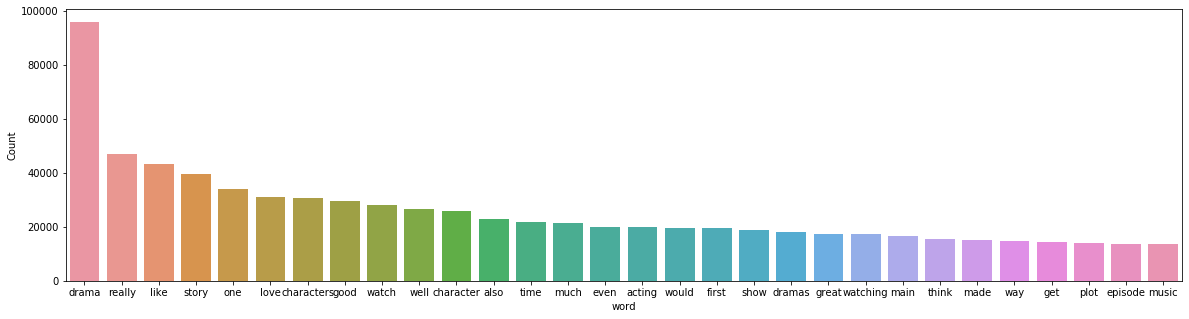

In [55]:
frequent_words(df['reviews_processed2x'])

These words are not the most meaningful. Words like 'watching' and 'dramas' are not in their base forms, and we see that 'watch' and 'drama' also appeared in this top 30 most frequent word list. Thus, we use spaCy to reduce words to its base form.

We can also note that there are other noise such as 'also' and 'think' which are not meaningful. Thus, we use lemmatization to pick only nouns and adjective.

In [56]:
nlp = spacy.load('en', disable=['parser', 'ner']) # reduce words to base form

def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
    output = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output

In [57]:
tokenized_reviews = df.apply(lambda row: row['reviews_processed2x'].split(), axis=1)
print(tokenized_reviews[0])

['thank', 'writer', 'noh', 'making', 'heart', 'warming', 'story', 'come', 'live', 'enjoy', 'drama', 'much', 'always', 'keeps', 'excited', 'weekends', 'laugh', 'hard', 'cry', 'even', 'harder', 'till', 'head', 'eyes', 'hurt', 'almost', 'every', 'episode', 'much', 'feels', 'watched', 'drama', 'much', 'life', 'lesson', 'learned', 'makes', 'think', 'future', 'life', 'get', 'older', 'later', 'cherish', 'time', 'even', 'every', 'time', 'finished', 'watching', 'episode', 'miss', 'mom', 'feel', 'like', 'calling', 'say', 'drama', 'taken', 'special', 'place', 'heart', 'drama', 'beautifully', 'made', 'feel', 'much', 'heart', 'put', 'hats', 'senior', 'actors', 'everybody', 'great', 'job', 'even', 'find', 'flaws', 'complained', 'much', 'things', 'say', 'put', 'words', 'watching', 'soon', 'waiting', 'writer', 'noh', 'next', 'drama', 'sure']


In [58]:
lemmatized_reviews = lemmatization(tokenized_reviews)
print(lemmatized_reviews[0])

['heart', 'warming', 'story', 'live', 'drama', 'excited', 'weekend', 'hard', 'head', 'eye', 'episode', 'much', 'drama', 'much', 'life', 'lesson', 'future', 'life', 'old', 'cherish', 'time', 'time', 'episode', 'mom', 'drama', 'special', 'place', 'heart', 'drama', 'much', 'heart', 'hat', 'senior', 'actor', 'great', 'job', 'flaw', 'much', 'thing', 'word', 'writer', 'next', 'drama', 'sure']


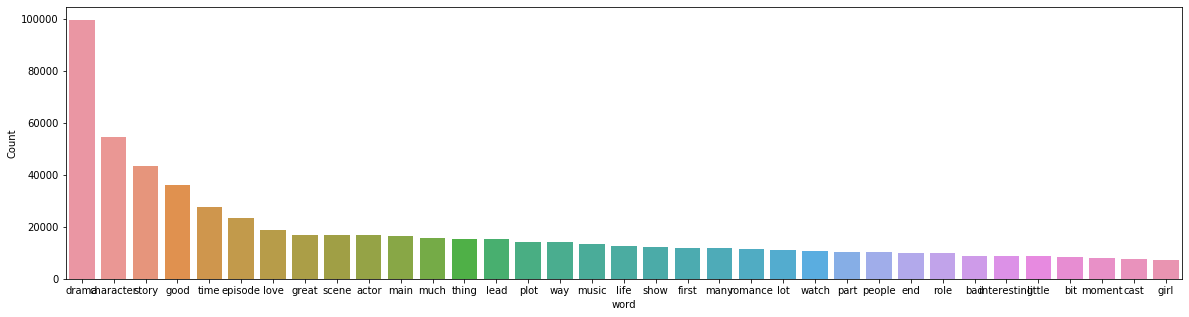

In [59]:
detokenized_reviews = []
for i in range(len(lemmatized_reviews)):
    detokenized_reviews.append(' '.join(lemmatized_reviews[i]))

df['reviews_lemmatized'] = detokenized_reviews

frequent_words(df['reviews_lemmatized'], 35)

Here, we see more meaningful words like "romance" and "interesting" coming up. These words tell more story compared to the removed words like "also" and "think".

## 7. Save processed reviews into new CSV

In [60]:
df.to_csv('drama_reviews_processed.csv', index=False)